## Part 1: Data Preprocessing and Dataset Definition

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import librosa
import os
from torch.nn.utils.rnn import pad_sequence

def extract_vowels_and_positions(phrase):
    vowels = "aeiou"
    vowels_in_phrase = []
    positions = []
    for idx, char in enumerate(phrase.lower()):
        if char in vowels:
            vowels_in_phrase.append(char)
            positions.append(idx)
    return vowels_in_phrase, positions

def get_tone_indices(tonal_sequence):
    tone_map = {'L': 0, 'H': 1}  # Map tones to indices
    return [tone_map.get(ch, -1) for ch in tonal_sequence.replace(' ', '')]

def preprocess_data(csv_file, wav_folder):
    df = pd.read_csv(csv_file, sep=";")
    processed_data = []

    for idx, row in df.iterrows():
        try:
            phrase = row['Phrase']
            tonal_sequence = row['TONAL SEQUENCE'].replace(' ', '')
            labels = get_tone_indices(tonal_sequence)
            vowels_in_phrase, positions = extract_vowels_and_positions(phrase)
            if len(labels) != len(vowels_in_phrase):
                print(f"Warning: Mismatch in number of vowels and tones for UID {row['UID']}. Skipping.")
                continue

            processed_data.append({
                'UID': row['UID'],
                'Phrase': phrase,
                'Labels': labels,
                'Vowel_Positions': positions
            })
        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")

    return pd.DataFrame(processed_data)

class TonalSequenceDataset(Dataset):
    def __init__(self, df, wav_folder):
        self.df = df
        self.wav_folder = wav_folder
        self.valid_data = self._get_valid_data()

    def _get_valid_data(self):
        return self.df[self.df['UID'].apply(
            lambda uid: os.path.exists(os.path.join(self.wav_folder, f"{uid}.wav"))
        )].reset_index(drop=True)

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        row = self.valid_data.iloc[idx]
        wav_path = os.path.join(self.wav_folder, f"{row['UID']}.wav")
        audio, sr = librosa.load(wav_path, sr=None)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Shape: (n_mfcc, time)
        mfcc = torch.FloatTensor(mfcc.T)  # Shape: (time, n_mfcc)

        # Map vowel positions to time indices
        phrase_length = len(row['Phrase'])
        audio_length = mfcc.size(0)
        time_indices = np.linspace(0, audio_length - 1, phrase_length).astype(int)
        vowel_time_indices = time_indices[row['Vowel_Positions']]

        labels = torch.LongTensor(row['Labels'])  # Target tones

        # Extract features at vowel positions
        vowel_features = mfcc[vowel_time_indices]

        return vowel_features, labels


## Part 2: Model Definition


In [ ]:
class VowelToneClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VowelToneClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x  # logits


## Part 3: Training and Evaluation Functions


In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.2 MB/s eta 0:00:00


In [ ]:
import torch.optim as optim
from collections import Counter

def compute_class_weights(train_dataset):
    all_labels = []
    for _, labels in train_dataset:
        all_labels.extend(labels.numpy())
    class_counts = Counter(all_labels)
    total_count = sum(class_counts.values())
    class_weights = [total_count / class_counts[i] for i in range(len(class_counts))]
    return torch.FloatTensor(class_weights)

def collate_fn(batch):
    vowel_features_list, labels_list = zip(*batch)
    vowel_features_padded = pad_sequence(vowel_features_list, batch_first=True)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=-1)

    return vowel_features_padded, labels_padded

def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch_idx, batch in enumerate(train_loader):
        vowel_features, labels = batch
        vowel_features = vowel_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(vowel_features)  # (batch_size, num_vowels, output_dim)
        outputs = outputs.view(-1, outputs.size(-1))  # Flatten outputs
        labels = labels.view(-1)

        # Remove padding positions
        mask = labels != -1
        outputs = outputs[mask]
        labels = labels[mask]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples * 100
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    total_edit_distance = 0
    total_length = 0

    with torch.no_grad():
        for batch in val_loader:
            vowel_features, labels = batch
            vowel_features = vowel_features.to(device)
            labels = labels.to(device)

            outputs = model(vowel_features)
            outputs = outputs.view(-1, outputs.size(-1))
            labels = labels.view(-1)

            # Remove padding positions
            mask = labels != -1
            outputs = outputs[mask]
            labels = labels[mask]

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Calculate CER
            pred_sequence = preds.cpu().numpy()
            target_sequence = labels.cpu().numpy()
            pred_sequence = [str(p) for p in pred_sequence]
            target_sequence = [str(t) for t in target_sequence]
            distance = Levenshtein.distance(''.join(pred_sequence), ''.join(target_sequence))
            total_edit_distance += distance
            total_length += len(target_sequence)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total_samples * 100
    cer = total_edit_distance / total_length if total_length > 0 else 0
    return avg_loss, accuracy, cer


## Part 4: Main Function with Metric Recording and Plotting


Loading and preprocessing data...
Training samples: 107
Validation samples: 27
Using device: cuda
Epoch 1 Results:
Train Loss: 0.6930, Train Accuracy: 52.67%
Val Loss: 0.6932, Val Accuracy: 50.68%
Character Error Rate (CER): 44.29%
Saving new best model with Validation Accuracy: 50.68%
Epoch 2 Results:
Train Loss: 0.6848, Train Accuracy: 54.37%
Val Loss: 0.6894, Val Accuracy: 55.25%
Character Error Rate (CER): 34.25%
Saving new best model with Validation Accuracy: 55.25%
Epoch 3 Results:
Train Loss: 0.6778, Train Accuracy: 58.57%
Val Loss: 0.6897, Val Accuracy: 53.42%
Character Error Rate (CER): 42.01%
Epoch 4 Results:
Train Loss: 0.6700, Train Accuracy: 57.21%
Val Loss: 0.6912, Val Accuracy: 56.16%
Character Error Rate (CER): 36.07%
Saving new best model with Validation Accuracy: 56.16%
Epoch 5 Results:
Train Loss: 0.6709, Train Accuracy: 56.87%
Val Loss: 0.6825, Val Accuracy: 55.25%
Character Error Rate (CER): 36.07%
Epoch 6 Results:
Train Loss: 0.6570, Train Accuracy: 61.18%
Val Los

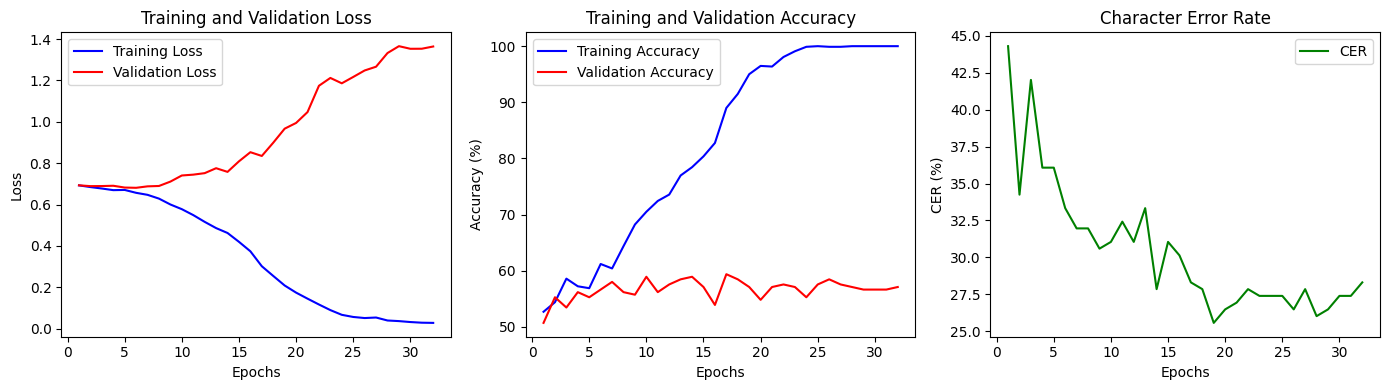

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, cer_list):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot CER
    plt.subplot(1, 3, 3)
    plt.plot(epochs, cer_list, 'g-', label='CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epochs')
    plt.ylabel('CER (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

def main():
    import Levenshtein

    # Set random seed for reproducibility
    set_seed(42)

    # Training parameters
    batch_size = 16
    learning_rate = 0.001
    num_epochs = 50  # You can adjust this
    hidden_dim = 128
    output_dim = 2  # 'L' or 'H'

    # Paths
    train_csv = "NLP_TONES_DATA.csv"
    wav_folder = "./drive/MyDrive/data/nlp/train"  # Update this path as needed

    print("Loading and preprocessing data...")
    df = preprocess_data(train_csv, wav_folder)

    train_df = df.sample(frac=0.8, random_state=42)
    val_df = df.drop(train_df.index)

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # Create datasets
    train_dataset = TonalSequenceDataset(train_df, wav_folder)
    val_dataset = TonalSequenceDataset(val_df, wav_folder)

    # Compute class weights
    class_weights = compute_class_weights(train_dataset)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model
    model = VowelToneClassifier(13, hidden_dim, output_dim).to(device)

    # Setup training components
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=-1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    cer_list = []

    # Early stopping parameters
    best_val_acc = 0
    patience = 15
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
        val_loss, val_acc, cer = evaluate(model, val_loader, criterion, device)

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        cer_list.append(cer * 100)  # Convert CER to percentage

        print(f"Epoch {epoch} Results:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print(f"Character Error Rate (CER): {cer:.2%}")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            print(f"Saving new best model with Validation Accuracy: {val_acc:.2f}%")
            torch.save(model.state_dict(), "best_tonal_sequence_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break

    print("Training completed!")

    # After training, plot the metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, cer_list)

if __name__ == "__main__":
    main()


## Part 5: Testing Code with MFCC and Waveform Plotting


Starting testing...


<ipython-input-9-d199dbc03b33>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


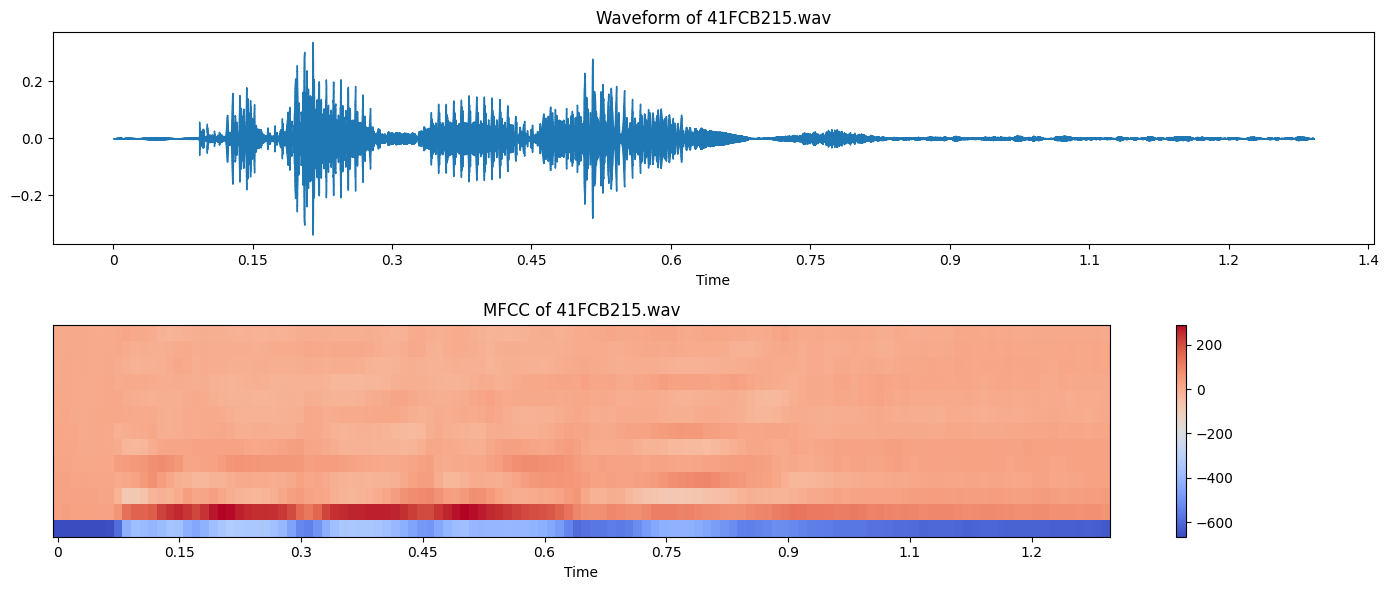


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/41FCB215.wav
Phrase: ba kgola mephutso
Predicted Tonal Sequence: H H L L L L
Expected Number of Tones: 6
Number of Tones Predicted: 6
--------------------------------------------------


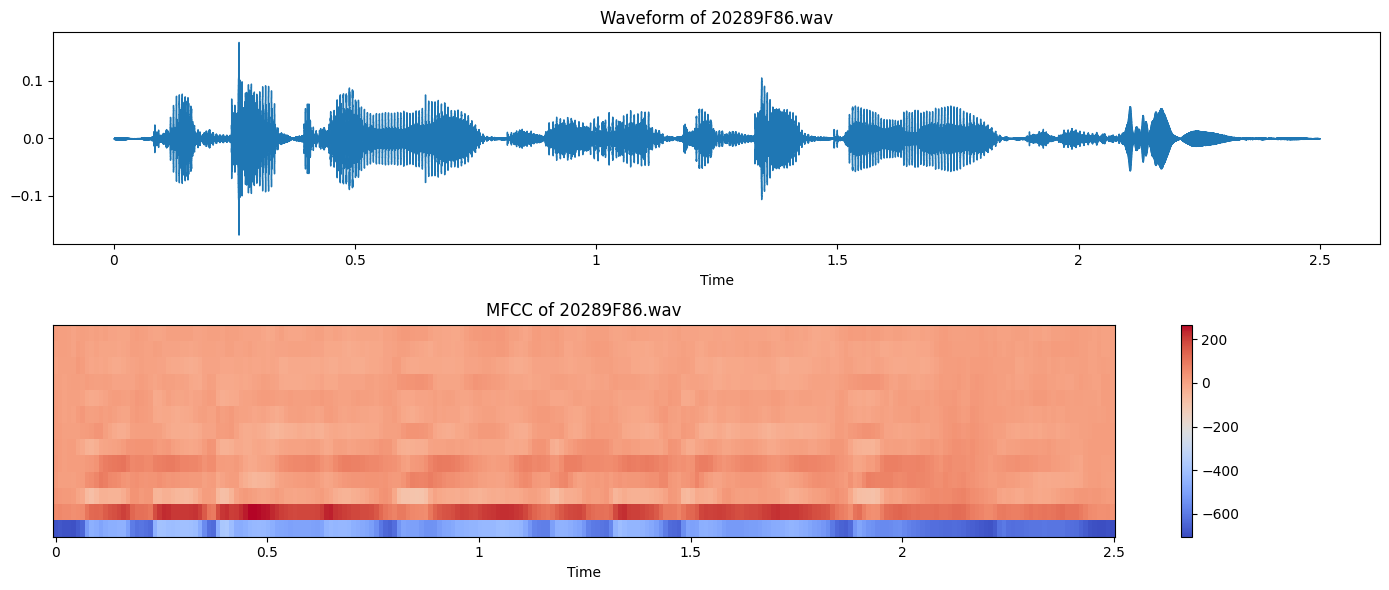


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/20289F86.wav
Phrase: Ho Roka Mose
Predicted Tonal Sequence: H L L H L
Expected Number of Tones: 5
Number of Tones Predicted: 5
--------------------------------------------------


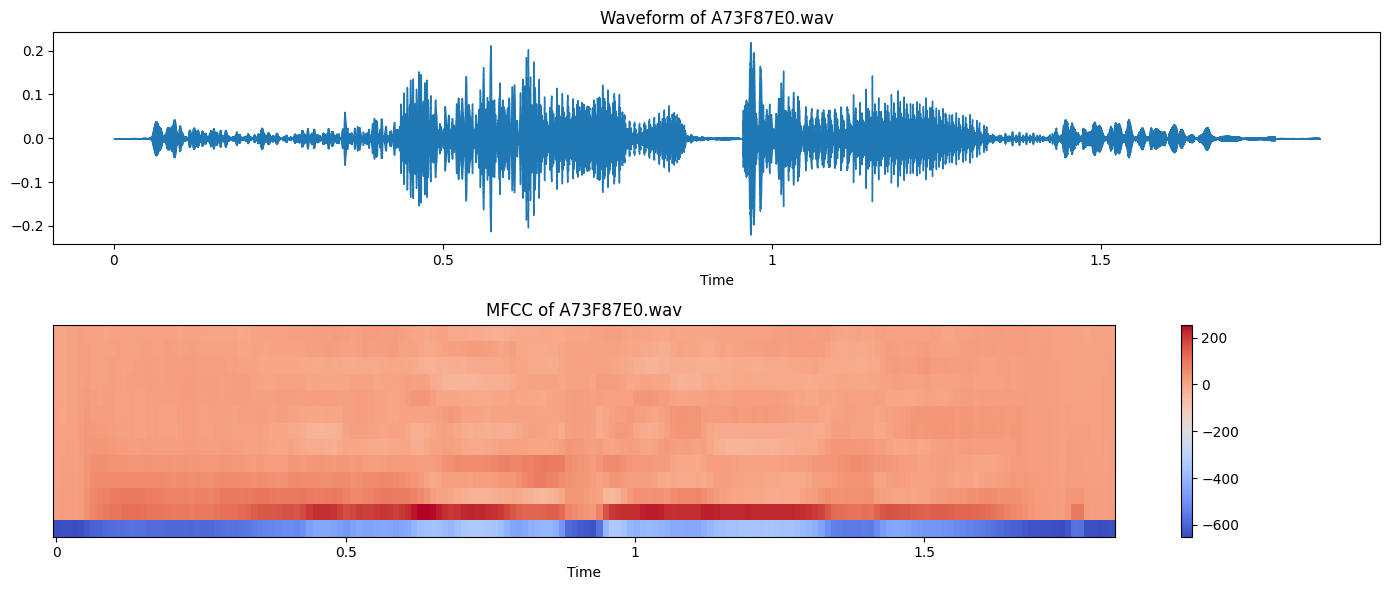


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/A73F87E0.wav
Phrase: Ho beha thebe Ho se behe thebe
Predicted Tonal Sequence: L L H H L H H L H L L
Expected Number of Tones: 11
Number of Tones Predicted: 11
--------------------------------------------------


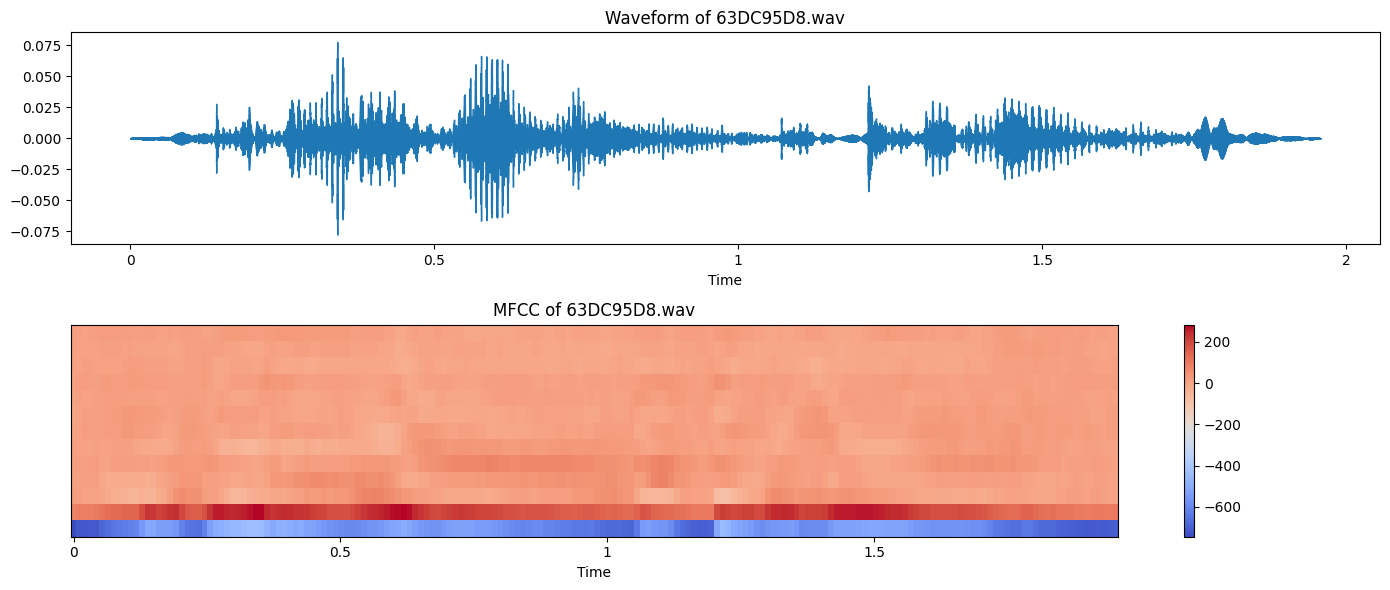


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/63DC95D8.wav
Phrase: Ha ba kgole ditholwana
Predicted Tonal Sequence: H H H H H L L L
Expected Number of Tones: 8
Number of Tones Predicted: 8
--------------------------------------------------


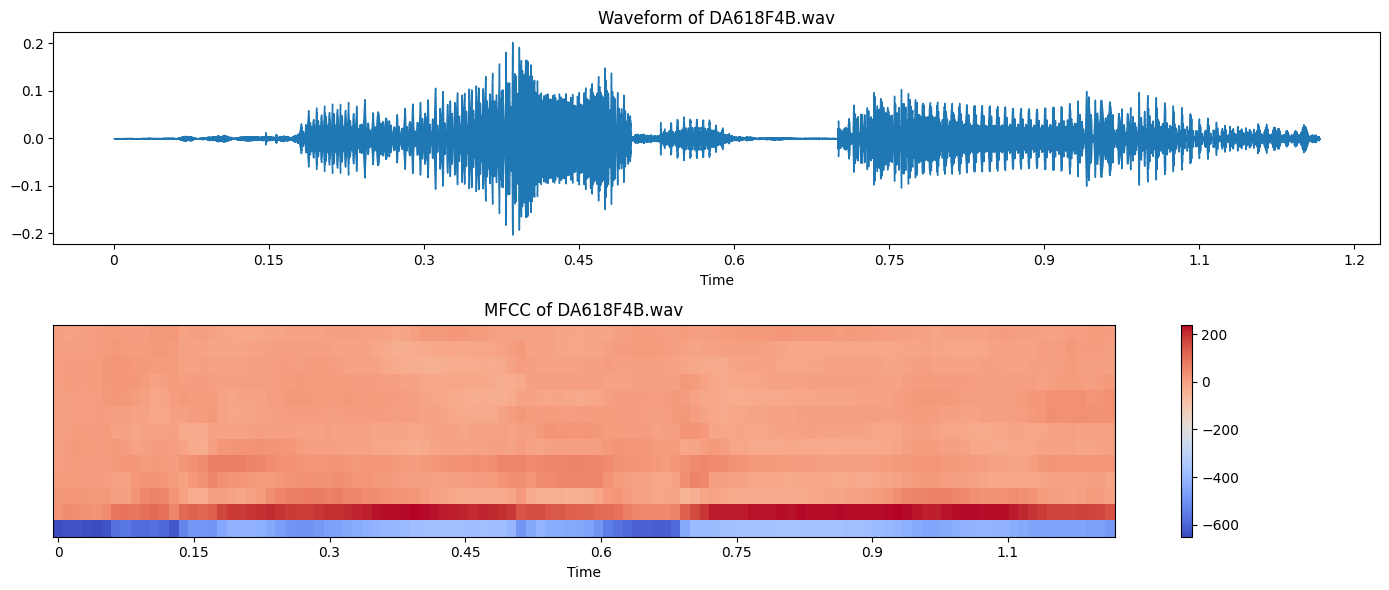


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/DA618F4B.wav
Phrase: Ke bua ditata
Predicted Tonal Sequence: L H H H L L
Expected Number of Tones: 6
Number of Tones Predicted: 6
--------------------------------------------------


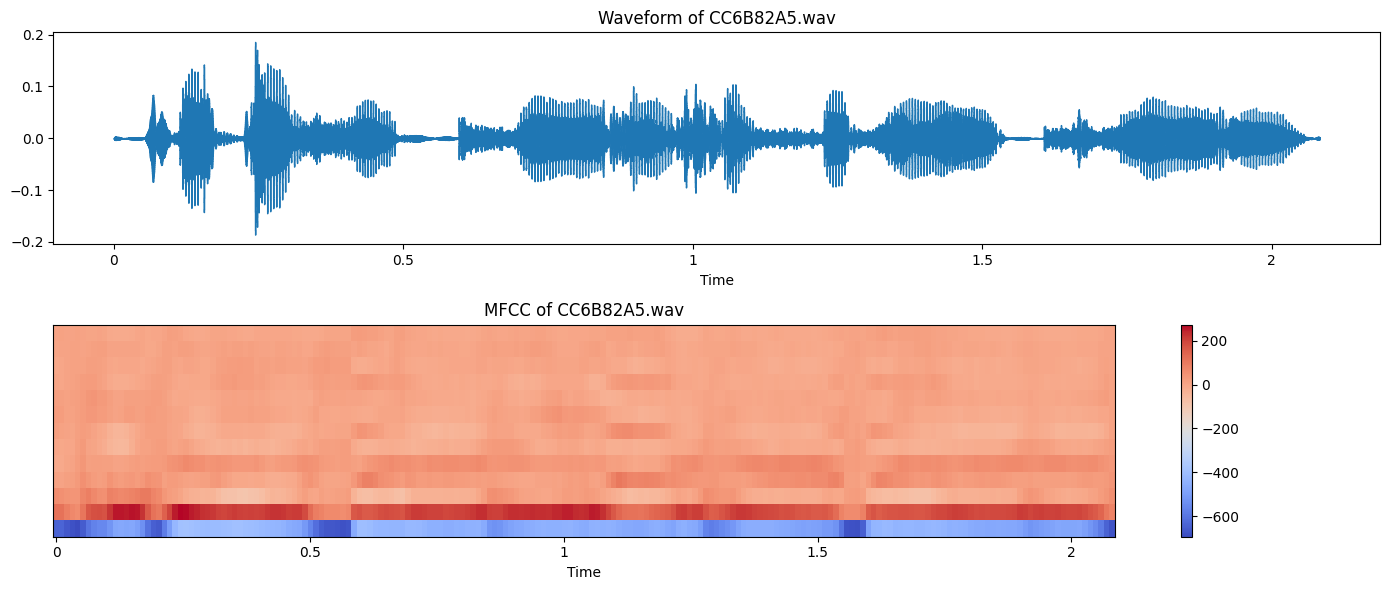


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/CC6B82A5.wav
Phrase: Ho beha thebe Ho se behe thebe
Predicted Tonal Sequence: L H H H L L H L H L L
Expected Number of Tones: 11
Number of Tones Predicted: 11
--------------------------------------------------


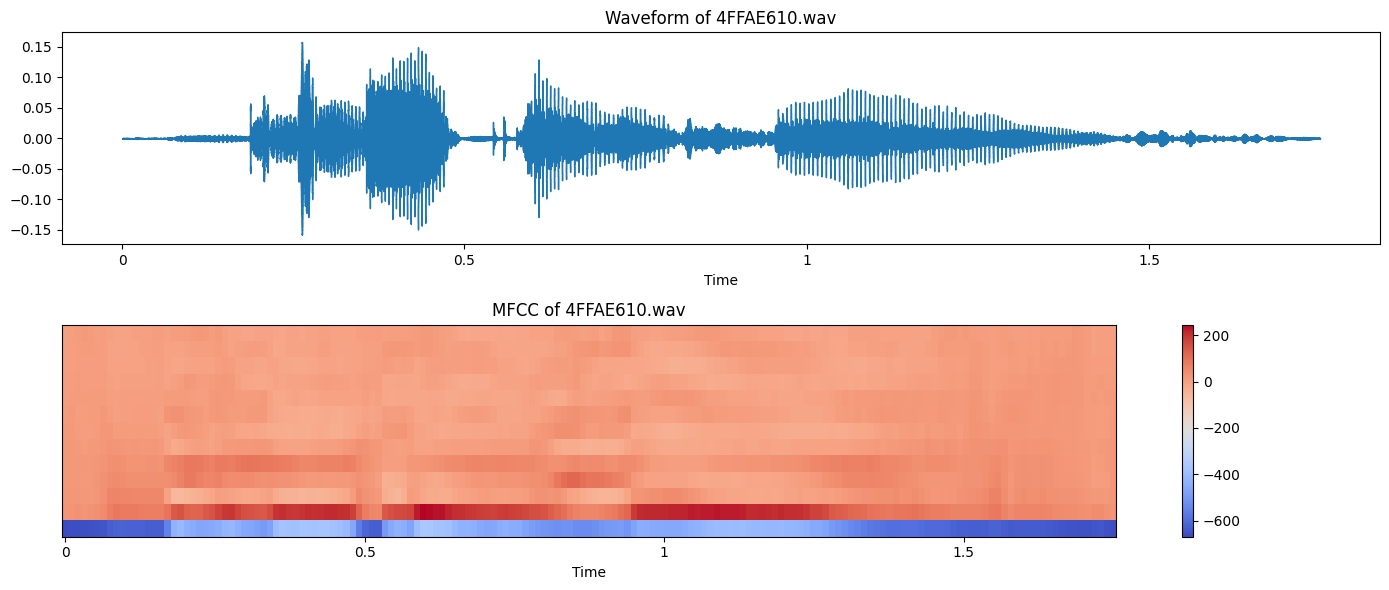


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/4FFAE610.wav
Phrase: Di leka letswai
Predicted Tonal Sequence: L H H L L L
Expected Number of Tones: 6
Number of Tones Predicted: 6
--------------------------------------------------


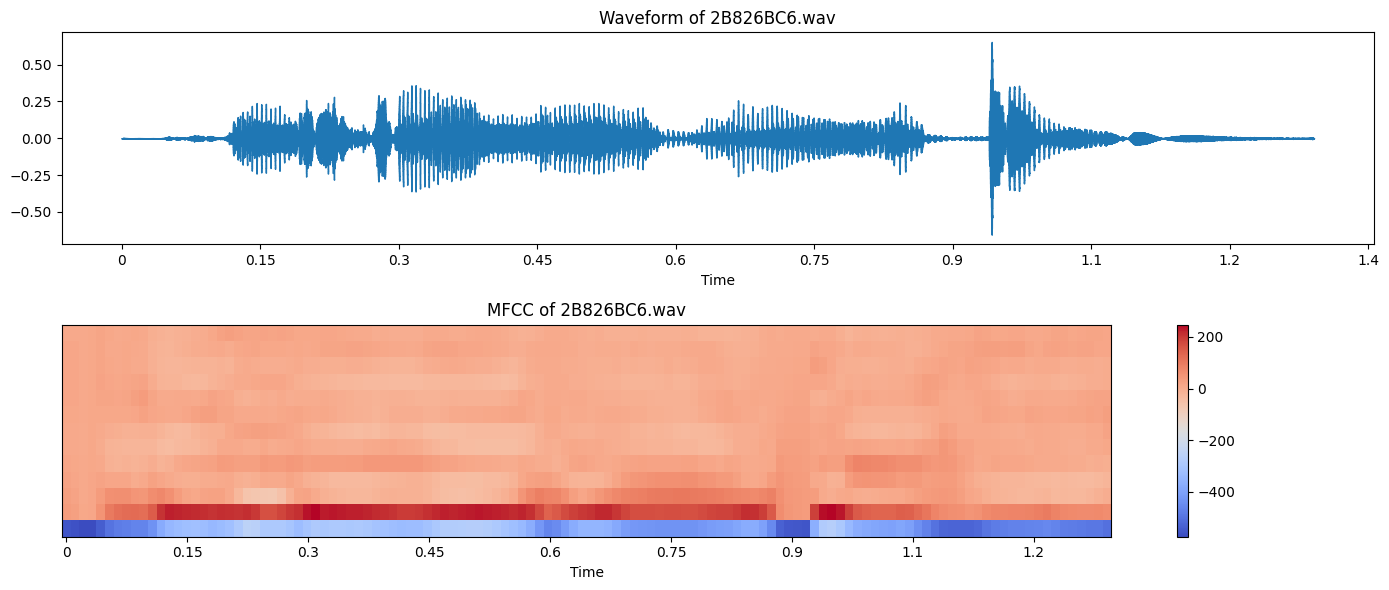


Prediction Result:
Audio File: ./drive/MyDrive/data/nlp/test/2B826BC6.wav
Phrase: Ho hlola bobe
Predicted Tonal Sequence: L L H L H
Expected Number of Tones: 5
Number of Tones Predicted: 5
--------------------------------------------------
Testing completed!


In [ ]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa.display

def extract_vowels_and_positions(phrase):
    vowels = "aeiou"
    vowels_in_phrase = []
    positions = []
    for idx, char in enumerate(phrase.lower()):
        if char in vowels:
            vowels_in_phrase.append(char)
            positions.append(idx)
    return vowels_in_phrase, positions

class VowelToneClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VowelToneClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x  # logits

def test_samples(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VowelToneClassifier(13, 128, 2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    test_base_path = "./drive/MyDrive/data/nlp/test"  # Update this path as needed
    test_files = [
        f"{test_base_path}/41FCB215.wav",
        f"{test_base_path}/20289F86.wav",
        f"{test_base_path}/A73F87E0.wav",
        # New
        f"{test_base_path}/63DC95D8.wav",
        f"{test_base_path}/DA618F4B.wav",
        f"{test_base_path}/CC6B82A5.wav",
        f"{test_base_path}/4FFAE610.wav",
        f"{test_base_path}/2B826BC6.wav"
    ]

    test_phrases = [
        "ba kgola mephutso",
        "Ho Roka Mose",
        "Ho beha thebe Ho se behe thebe",
        "Ha ba kgole ditholwana",
        "Ke bua ditata",
        "Ho beha thebe Ho se behe thebe",
        "Di leka letswai",
        "Ho hlola bobe"

        ]

    tone_map = {0: 'L', 1: 'H'}

    for audio_file, phrase in zip(test_files, test_phrases):
        try:
            # Load and process audio
            audio, sr = librosa.load(audio_file, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_tensor = torch.FloatTensor(mfcc.T).unsqueeze(0).to(device)  # (1, time, n_mfcc)

            # Plot Waveform and MFCC
            plt.figure(figsize=(14, 6))
            plt.subplot(2, 1, 1)
            librosa.display.waveshow(audio, sr=sr)
            plt.title(f'Waveform of {os.path.basename(audio_file)}')

            plt.subplot(2, 1, 2)
            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title(f'MFCC of {os.path.basename(audio_file)}')
            plt.tight_layout()
            # Save the figure
            if not os.path.exists('plots'):
                os.makedirs('plots')
            plt.savefig(f'plots/{os.path.basename(audio_file)}_waveform_mfcc.png')
            plt.show()

            # Get vowel positions and corresponding time indices
            vowels_in_phrase, positions = extract_vowels_and_positions(phrase)
            phrase_length = len(phrase)
            audio_length = mfcc_tensor.size(1)
            time_indices = np.linspace(0, audio_length - 1, phrase_length).astype(int)
            vowel_time_indices = time_indices[positions]

            # Extract features at vowel positions
            vowel_features = mfcc_tensor[:, vowel_time_indices, :]  # (1, num_vowels, n_mfcc)

            with torch.no_grad():
                outputs = model(vowel_features)  # (1, num_vowels, output_dim)
                preds = torch.argmax(outputs, dim=2).cpu().numpy()[0]
                pred_tones = [tone_map[p] for p in preds]

            print("\nPrediction Result:")
            print(f"Audio File: {audio_file}")
            print(f"Phrase: {phrase}")
            print(f"Predicted Tonal Sequence: {' '.join(pred_tones)}")
            print(f"Expected Number of Tones: {len(vowels_in_phrase)}")
            print(f"Number of Tones Predicted: {len(pred_tones)}")
            print("-" * 50)

        except Exception as e:
            print(f"\nError processing {audio_file}:")
            print(f"Error message: {str(e)}")
            print("-" * 50)

if __name__ == "__main__":
    # Ensure that the model has been trained and saved as 'best_tonal_sequence_model.pth'
    model_path = "best_tonal_sequence_model.pth"
    print("Starting testing...")
    test_samples(model_path)
    print("Testing completed!")
